## Derivative inversion

### Author: M.Ravasi

In this notebook we consider the process of computing the derivative of a noisy signal. Instead of doing so directly with a FD stencil, we recast this as an inverse problem where the modelling operator is the `CausalIntegration` operator.

See https://www.hindawi.com/journals/isrn/2011/164564/ and https://github.com/smrfeld/Total-Variation-Regularization-Derivative-Python for details

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import pylops

from functools import partial
from scipy import integrate
from scipy import optimize
from scipy.sparse import csr_matrix, vstack, rand
from scipy.linalg import lstsq, solve, pinv
from scipy.sparse.linalg import LinearOperator as spLinearOperator
from scipy.sparse.linalg import cg, lsqr

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity  import FISTA, SplitBregman

In [2]:
np.random.seed(10)

In [3]:
import numpy as np
from pylops import LinearOperator


class CausalIntegration(LinearOperator):
    r"""Causal integration.

    Apply causal integration to a multi-dimensional array along ``dir`` axis.

    Parameters
    ----------
    N : :obj:`int`
        Number of samples in model.
    dims : :obj:`list`, optional
        Number of samples for each dimension
        (``None`` if only one dimension is available)
    dir : :obj:`int`, optional
        Direction along which smoothing is applied.
    sampling : :obj:`float`, optional
        Sampling step ``dx``.
    halfcurrent : :obj:`bool`, optional
        Add half of current value (``True``) or the entire value (``False``)
    trapezoidal : :obj:`bool`, optional
        Apply trapezoidal rule (``True``) or not (``False``)
    dtype : :obj:`str`, optional
        Type of elements in input array.

    Attributes
    ----------
    shape : :obj:`tuple`
        Operator shape
    explicit : :obj:`bool`
        Operator contains a matrix that can be solved explicitly (``True``)
        or not (``False``)

    Notes
    -----
    The CausalIntegration operator applies a causal integration to any chosen
    direction of a multi-dimensional array.

    For simplicity, given a one dimensional array, the causal integration is:

    .. math::
        y(t) = \int x(t) dt

    which can be discretised as :

    .. math::
        y[i] = \sum_{j=0}^i x[j] dt

    or

    .. math::
        y[i] = (\sum_{j=0}^{i-1} x[j] + 0.5x[i]) dt

    or

    .. math::
        y[i] = (\sum_{j=1}^{i-1} x[j] + 0.5x[0] + 0.5x[i]) dt

    where :math:`dt` is the ``sampling`` interval. In our implementation, the
    choice to add :math:`x[i]` or :math:`0.5x[i]` is made by selecting
    the ``halfcurrent`` parameter and the choice to add :math:`x[0]` or
    :math:`0.5x[0]` is made by selecting the ``trapezoidal`` parameter.

    Note that the integral of a signal has no unique solution, as any constant
    :math:`c` can be added to :math:`y`, for example if :math:`x(t)=t^2` the
    resulting integration is:

    .. math::
        y(t) = \int t^2 dt = \frac{t^3}{3} + c

    If we apply a first derivative to :math:`y` we in fact obtain:

    .. math::
        x(t) = \frac{dy}{dt} = t^2

    no matter the choice of :math:`c`.

    """
    def __init__(self, N, dims=None, dir=-1, sampling=1,
                 halfcurrent=True, trapezoidal=False, removefirst=False,
                 dtype='float64'):
        self.N = N
        self.dir = dir
        self.sampling = sampling
        self.trapezoidal = trapezoidal
        self.halfcurrent = halfcurrent if not trapezoidal else False
        self.removefirst = removefirst
        if dims is None:
            self.dims = [self.N, 1]
            self.reshape = False
        else:
            if np.prod(dims) != self.N:
                raise ValueError('product of dims must equal N!')
            else:
                self.dims = dims
                self.reshape = True
        self.shape = (self.N-self.dims[self.dir] if self.removefirst else self.N,
                      self.N)
        self.dtype = np.dtype(dtype)
        self.explicit = False

    def _matvec(self, x):
        if self.reshape:
            x = np.reshape(x, self.dims)
        if self.dir != -1:
            x = np.swapaxes(x, self.dir, -1)
        y = self.sampling * np.cumsum(x, axis=-1)
        if self.halfcurrent or self.trapezoidal:
            y -= self.sampling * x / 2.
        if self.trapezoidal:
            y[1:] -= self.sampling * x[0] / 2.
        if self.removefirst:
            y = y[1:]
        if self.dir != -1:
            y = np.swapaxes(y, -1, self.dir)
        return y.ravel()

    def _rmatvec(self, x):
        if self.reshape:
            x = np.reshape(x, self.dims)
        if self.removefirst:
            x = np.insert(x, 0, 0, axis=self.dir)
        if self.dir != -1:
            x = np.swapaxes(x, self.dir, -1)
        xflip = np.flip(x, axis=-1)
        if self.halfcurrent:
            y = self.sampling * (np.cumsum(xflip, axis=-1) - xflip / 2.)
        elif self.trapezoidal:
            y = self.sampling * (np.cumsum(xflip, axis=-1) - xflip / 2.)
            y[-1] = self.sampling * np.sum(xflip, axis=-1) / 2.
        else:
            y = self.sampling * np.cumsum(xflip, axis=-1)
        #y = self.sampling * np.cumsum(xflip, axis=-1)
        #if self.halfcurrent or self.trapezoidal:
        #    y -= self.sampling * xflip / 2.
        #if self.trapezoidal:
        #    y[-1] = self.sampling * np.sum(xflip, axis=-1) / 2.
        y = np.flip(y, axis=-1)
        if self.dir != -1:
            y = np.swapaxes(y, -1, self.dir)
        return y.ravel()


In [4]:
Cop = CausalIntegration(4, sampling=1, halfcurrent=True, removefirst=True)
dottest(Cop, verb=True)

Cop * np.ones(4), Cop.todense()

Dot test passed, v^T(Opu)=0.264101 - u^T(Op^Tv)=0.264101


(array([1.5, 2.5, 3.5]),
 array([[1. , 0.5, 0. , 0. ],
        [1. , 1. , 0.5, 0. ],
        [1. , 1. , 1. , 0.5]]))

In [17]:
Cop = CausalIntegration(4, sampling=1, trapezoidal=True, removefirst=True)
dottest(Cop)

Cop.todense(), Cop.H.todense()

(array([[0.5, 0.5, 0. , 0. ],
        [0.5, 1. , 0.5, 0. ],
        [0.5, 1. , 1. , 0.5]]),
 array([[0.5, 0.5, 0.5],
        [0.5, 1. , 1. ],
        [0. , 0.5, 1. ],
        [0. , 0. , 0.5]]))

In [6]:
class DiffTVR:

    def __init__(self, dx: float, n: int):
        """Differentiate with TVR.
        Args:
            dx (float): Spacing of data.
            n (int): Number of points in data.
        """
        self.Dop = None
        self.CIop = None
        self.eps = 1e-10

        self.n = n
        self.dx = dx
        self.build_matrices()

    def build_matrices(self):
        self.Dop = pylops.Restriction(self.n, np.arange(self.n-1)) * \
            pylops.FirstDerivative(self.n, kind='forward', edge=True,
                                   sampling=self.dx)
        self.CIop = CausalIntegration(self.n, sampling=self.dx, trapezoidal=True, removefirst=True)
        #TrapezoidalIntegration(self._n, sampling=self._dx)

    def __call__(self, data: np.array, alpha: float, *,
                 initial_guess: np.array, steps: int,
                 dx: float = None) -> np.array:
        """Get derivative via TVR over optimization steps
        Args:
            data (np.array): Data 
            initial_guess (np.array): Guess for derivative
            alpha (float): Regularization parameter
            steps (int): No. opt steps to run
        Returns:
            np.array: estimated derivative
            np.array: integrated derivative
        """
        self._dx = dx if dx is not None else self.dx
        self.n = data.size  # triggers update of matrices
        eps = pow(10,-6)
        KTK = self.CIop.T * self.CIop
        deriv_curr = initial_guess
        for s in range(0, steps):
            # Compute update
            en_diag = 1. / np.sqrt((self.Dop * deriv_curr) ** 2 + eps)
            HOp = KTK + alpha * self._dx * self.Dop.H * pylops.Diagonal(en_diag) * self.Dop
            g = HOp * deriv_curr - self.CIop.T * data
            update = solve(HOp.todense(), -g)
            #update1 = lsqr(HOp, -g, iter_lim=1000)[0]
            #print(np.linalg.norm(update-update1))
            # Update solution
            deriv_curr += update

        # Estimate integral
        func = self.CIop * deriv_curr
        return deriv_curr, func


In [7]:
import numpy as np
from scipy.linalg import solve

from typing import Tuple

class DiffTVR1:

    def __init__(self, n: int, dx: float):
        """Differentiate with TVR.

        Args:
            n (int): Number of points in data.
            dx (float): Spacing of data.
        """
        self.n = n
        self.dx = dx

        self.d_mat = self._make_d_mat()
        self.a_mat = self._make_a_mat()
        self.a_mat_t = self._make_a_mat_t()

    def _make_d_mat(self) -> np.array:
        """Make differentiation matrix with central differences. NOTE: not efficient!

        Returns:
            np.array: N x N+1
        """
        arr = np.zeros((self.n,self.n+1))
        for i in range(0,self.n):
            arr[i,i] = -1.0
            arr[i,i+1] = 1.0
        return arr / self.dx

    # TODO: improve these matrix constructors
    def _make_a_mat(self) -> np.array:
        """Make integration matrix with trapezoidal rule. NOTE: not efficient!

        Returns:
            np.array: N x N+1
        """
        arr = np.zeros((self.n+1,self.n+1))
        for i in range(0,self.n+1):
            if i==0:
                continue
            for j in range(0,self.n+1):
                if j==0:
                    arr[i,j] = 0.5
                elif j<i:
                    arr[i,j] = 1.0
                elif i==j:
                    arr[i,j] = 0.5
        
        return arr[1:] * self.dx

    def _make_a_mat_t(self) -> np.array:
        """Transpose of the integration matirx with trapezoidal rule. NOTE: not efficient!

        Returns:
            np.array: N+1 x N
        """
        smat = np.ones((self.n+1,self.n))
        
        cmat = np.zeros((self.n,self.n))
        li = np.tril_indices(self.n)
        cmat[li] = 1.0

        dmat = np.diag(np.full(self.n,0.5))

        vec = np.array([np.full(self.n,0.5)])
        combmat = np.concatenate((vec, cmat - dmat))

        return (smat - combmat) * self.dx

    def make_en_mat(self, deriv_curr : np.array) -> np.array:
        """Diffusion matrix

        Args:
            deriv_curr (np.array): Current derivative of length N+1

        Returns:
            np.array: N x N
        """
        eps = pow(10,-6)
        vec = 1.0/np.sqrt(pow(self.d_mat @ deriv_curr,2) + eps)
        return np.diag(vec)

    def make_ln_mat(self, en_mat : np.array) -> np.array:
        """Diffusivity term

        Args:
            en_mat (np.array): Result from make_en_mat

        Returns:
            np.array: N+1 x N+1
        """
        return self.dx * np.transpose(self.d_mat) @ en_mat @ self.d_mat

    def make_gn_vec(self, deriv_curr : np.array, data : np.array, alpha : float, ln_mat : np.array) -> np.array:
        """Negative right hand side of linear problem

        Args:
            deriv_curr (np.array): Current derivative of size N+1
            data (np.array): Data of size N
            alpha (float): Regularization parameter
            ln_mat (np.array): Diffusivity term from make_ln_mat

        Returns:
            np.array: Vector of length N+1
        """
        return self.a_mat_t @ self.a_mat @ deriv_curr - self.a_mat_t @ (data - data[0]) + alpha * ln_mat @ deriv_curr
    
    def make_hn_mat(self, alpha : float, ln_mat : np.array) -> np.array:
        """Matrix in linear problem

        Args:
            alpha (float): Regularization parameter
            ln_mat (np.array): Diffusivity term from make_ln_mat

        Returns:
            np.array: N+1 x N+1
        """
        return self.a_mat_t @ self.a_mat + alpha * ln_mat
    
    def get_deriv_tvr_update(self, data : np.array, deriv_curr : np.array, alpha : float) -> np.array:
        """Get the TVR update

        Args:
            data (np.array): Data of size N
            deriv_curr (np.array): Current deriv of size N+1
            alpha (float): Regularization parameter

        Returns:
            np.array: Update vector of size N+1
        """

        n = len(data)
    
        en_mat = self.make_en_mat(
            deriv_curr=deriv_curr
            )

        ln_mat = self.make_ln_mat(
            en_mat=en_mat
            )

        hn_mat = self.make_hn_mat(
            alpha=alpha,
            ln_mat=ln_mat
            )

        gn_vec = self.make_gn_vec(
            deriv_curr=deriv_curr,
            data=data,
            alpha=alpha,
            ln_mat=ln_mat
            )
        #print(gn_vec)
        return solve(hn_mat, -gn_vec)

    def get_deriv_tvr(self, 
        data : np.array, 
        deriv_guess : np.array, 
        alpha : float,
        no_opt_steps : int,
        return_progress : bool = False, 
        return_interval : int = 1
        ) -> Tuple[np.array,np.array]:
        """Get derivative via TVR over optimization steps

        Args:
            data (np.array): Data of size N
            deriv_guess (np.array): Guess for derivative of size N+1
            alpha (float): Regularization parameter
            no_opt_steps (int): No. opt steps to run
            return_progress (bool, optional): True to return derivative progress during optimization. Defaults to False.
            return_interval (int, optional): Interval at which to store derivative if returning. Defaults to 1.

        Returns:
            Tuple[np.array,np.array]: First is the final derivative of size N+1, second is the stored derivatives if return_progress=True of size no_opt_steps+1 x N+1, else [].
        """

        deriv_curr = deriv_guess

        if return_progress:
            deriv_st = np.full((no_opt_steps+1, len(deriv_guess)), 0)
        else:
            deriv_st = np.array([])

        for opt_step in range(0,no_opt_steps):
            update = self.get_deriv_tvr_update(
                data=data,
                deriv_curr=deriv_curr,
                alpha=alpha
                )
            #print(update)
            deriv_curr += update

            if return_progress:
                if opt_step % return_interval == 0:
                    deriv_st[int(opt_step / return_interval)] = deriv_curr

        return (deriv_curr, deriv_st)

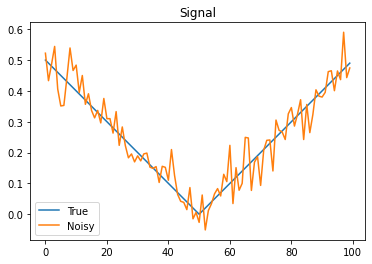

In [8]:
# Data
dx = 0.01

data = []
for x in np.arange(0,1,dx):
    data.append(abs(x-0.5))
data = np.array(data)

# True derivative
deriv_true = []
for x in np.arange(0,1,dx):
    if x < 0.5:
        deriv_true.append(-1)
    else:
        deriv_true.append(1)
deriv_true = np.array(deriv_true)

# Add noise
n = len(data)
data_noisy = data + np.random.normal(0,0.05,n)

# Plot true and noisy signal
fig1 = plt.figure()
plt.plot(data)
plt.plot(data_noisy)
plt.title("Signal")
plt.legend(["True","Noisy"])

diff_tvr = DiffTVR(dx, n+1)
deriv, data_tv = diff_tvr(data=data_noisy - data_noisy[0], initial_guess=np.zeros(n+1), 
                          alpha=0.2, steps=100)
data_tv += data_noisy[0]

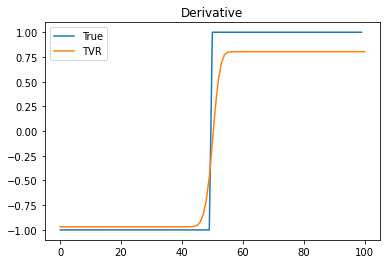

In [9]:
# Plot TVR derivative
fig2 = plt.figure()
plt.plot(deriv_true)
plt.plot(deriv)
plt.title("Derivative")
plt.legend(["True","TVR"])

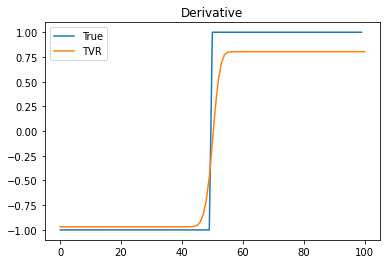

In [10]:
# Derivative with TVR
diff_tvr1 = DiffTVR1(n,dx)
(deriv,_) = diff_tvr1.get_deriv_tvr(
    data=data_noisy, 
    deriv_guess=np.full(n+1,0.0), 
    alpha=0.2,
    no_opt_steps=100
    )

# Plot TVR derivative
fig2 = plt.figure()
plt.plot(deriv_true)
plt.plot(deriv)
plt.title("Derivative")
plt.legend(["True","TVR"])

Compare dense vs log DiffTVR codes

In [11]:
diff_tvr1 = DiffTVR1(n,dx)

print(diff_tvr.Dop.todense() - diff_tvr1.d_mat)
print(diff_tvr.CIop.todense() - diff_tvr1.a_mat)
print(diff_tvr.CIop.H.todense() - diff_tvr1.a_mat_t)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [12]:
# make_en_mat
deriv_curr = np.random.normal(0, 1, n+1)    
eps = pow(10,-6)
        
np.diag(diff_tvr1.make_en_mat(deriv_curr)) - (1. / np.sqrt((diff_tvr.Dop * deriv_curr) ** 2 + eps))

array([ 5.55111512e-17, -3.46944695e-18,  1.38777878e-17,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00, -8.67361738e-19, -1.73472348e-18,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.46944695e-18,  0.00000000e+00, -3.46944695e-18,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.73472348e-18,
        0.00000000e+00,  0.00000000e+00,  8.67361738e-19,  3.46944695e-18,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.73472348e-18,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -4.16333634e-17,
        0.00000000e+00,  0.00000000e+00,  3.46944695e-18,  0.00000000e+00,
       -3.46944695e-18, -1.73472348e-18,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -3.46944695e-18,  0.00000000e+00,  0.00000000e+00,
       -1.73472348e-18, -

In [13]:
# make_ln_mat
alpha = 0.1
en_diag = np.random.normal(0.,1.,n)
en_diag[0] = 0

ln_op = dx * diff_tvr.Dop.H * pylops.Diagonal(en_diag) * diff_tvr.Dop
ln_mat = diff_tvr1.make_ln_mat(np.diag(en_diag))

np.linalg.norm(ln_op.todense()), np.linalg.norm(ln_op.todense() - ln_mat)

(1803.9667997623642, 1.6785575325120194e-13)

In [14]:
# make_hn_mat
hnOp = diff_tvr.CIop.H * diff_tvr.CIop + alpha * ln_op
np.linalg.norm(hnOp.todense()), np.linalg.norm(hnOp.todense() - diff_tvr1.make_hn_mat(alpha, ln_mat))

(180.39717038349906, 1.5783838855172682e-14)

In [15]:
(hnOp * deriv_curr) - (diff_tvr1.make_hn_mat(alpha, ln_mat) @ deriv_curr)

array([-3.12250226e-17,  8.88178420e-16, -8.88178420e-16,  0.00000000e+00,
       -3.55271368e-15,  9.99200722e-16,  7.10542736e-15, -2.13162821e-14,
       -2.48689958e-14, -2.22044605e-16,  1.66533454e-15,  2.66453526e-15,
       -8.88178420e-16, -8.88178420e-16, -1.77635684e-15, -1.77635684e-15,
        1.77635684e-15, -4.44089210e-16, -4.44089210e-16, -1.77635684e-15,
        1.77635684e-15,  0.00000000e+00,  7.10542736e-15,  1.77635684e-15,
        7.10542736e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.77635684e-15, -1.77635684e-15, -7.10542736e-15,  5.32907052e-15,
        7.10542736e-15,  3.10862447e-15,  0.00000000e+00, -5.55111512e-16,
        7.10542736e-15, -1.77635684e-15,  0.00000000e+00,  0.00000000e+00,
        1.11022302e-15,  1.11022302e-15,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.42108547e-14,  8.88178420e-16, -8.88178420e-16,
        3.55271368e-15,  3.55271368e-15, -8.88178420e-16, -1.33226763e-15,
        1.77635684e-15,  

In [16]:
# make_gn_vec
(hnOp * deriv_curr - diff_tvr.CIop.T * (data-data[0]))- (diff_tvr1.make_gn_vec(deriv_curr, data, alpha, ln_mat))

array([ 0.00000000e+00,  8.88178420e-16,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.44249065e-15,  3.55271368e-15, -7.10542736e-15,
        3.55271368e-15, -6.66133815e-16,  1.11022302e-15,  1.77635684e-15,
       -8.88178420e-16,  8.88178420e-16,  0.00000000e+00, -1.77635684e-15,
        8.88178420e-16, -1.11022302e-16,  0.00000000e+00, -2.66453526e-15,
        1.77635684e-15,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.42108547e-14,  0.00000000e+00, -1.77635684e-15,  0.00000000e+00,
       -3.55271368e-15, -8.88178420e-16, -3.55271368e-15,  3.55271368e-15,
        7.10542736e-15,  4.44089210e-16,  1.77635684e-15, -7.77156117e-16,
        1.77635684e-15, -1.77635684e-15, -8.88178420e-16, -8.88178420e-16,
        9.99200722e-16,  6.66133815e-16, -8.88178420e-16,  7.10542736e-15,
        0.00000000e+00,  0.00000000e+00,  1.77635684e-15, -8.88178420e-16,
        0.00000000e+00,  3.55271368e-15,  0.00000000e+00, -4.44089210e-16,
        8.88178420e-16,  